(qml102)=
# QML 102 - Deeper Classifiers


In the [last tutorial](qml101) we saw the most basic ideas of quantum machine learning algorithms. They included:

- division in training and test data
- simple training
- accuracy tests.

However, all of this happened in an extremely simple case, which allowed us to work with simple algorithms. In this tutorial, we will discuss the possibility to learn more complicated structures with deeper circuits. As in the last tutorial, the task will be once again  the classification of data points $x_i$ with labels $y_i$. However the structure will be more complicated, such that the previous circuits would fail. So in this tutorial we will learn:

- deeper reuploading circuits
- training with optimizers.
- All circuits will be implemented with `qiskit` because of its wide ranging use.

We will always focus on simplicity throughout this tutorial and leave the more complex discussions to the extensive literature and later tutorials.

In [ ]:
# only necessary on colab to have all the required packages installed

!pip install qiskit
!pip install pylatexenc

## The learning  task

As previously, we will focus on a problem with one dimensional input data, which we associate with a label {0, 1}. However, the data set has a strucute, which will require deeper circuits.

In [ ]:
from typing import Union, List

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# for splitting the data set
from sklearn.model_selection import train_test_split

# for the quantum circuits
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer

Text(0, 0.5, 'label')

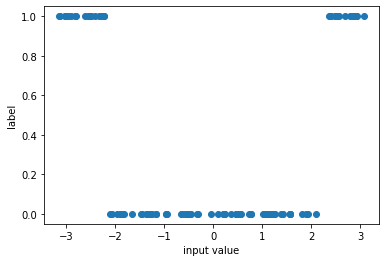

In [ ]:
np.random.seed(1)
x = np.random.uniform(-np.pi, np.pi, 100)
y = 1.0 * (abs(x) > 1.4*np.pi/2)

f, ax = plt.subplots()
ax.plot(x, y, "o")
ax.set_xlabel("input value")
ax.set_ylabel("label")

Once again we split the data set and get into the training.

Text(0.5, 1.0, 'test data')

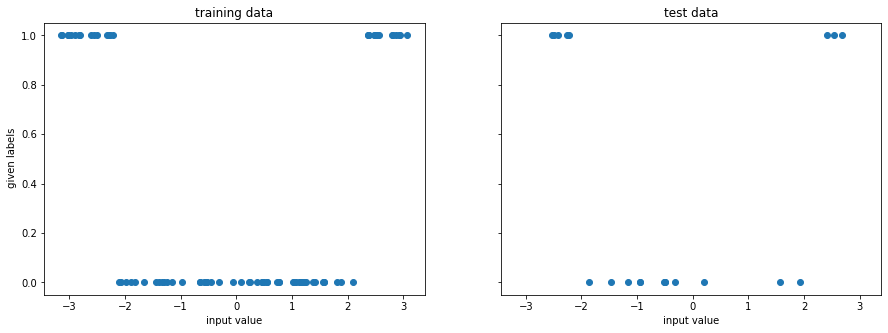

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42
)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax1.plot(x_train, y_train, "o")
ax1.set_xlabel("input value")
ax1.set_ylabel(" given labels")
ax1.set_title("training data")

ax2.plot(x_test, y_test, "o")
ax2.set_xlabel("input value")
ax2.set_title("test data")

## A deeper algorithm


To achieve training for this more complex data set we have to work with a [data-reuploading approach](https://quantum-journal.org/papers/q-2020-02-06-226/). It is similiar to our previous approach as it does the following.

1. Prepare the initial state.
2. Apply a parametrized circuit with parameters $\mathbf{w}$ that depend on the input $U(\mathbf{w}, x_i)$.
3. Read out the label from the measurement of the qubit.

However, the circuit has now a structure, where input parameter is is applied again and again, interleaved with some processing layer. This allows for non-trivial classification tasks, which was analyzed in great detail [here](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.032430).

In [ ]:
sim = Aer.get_backend("aer_simulator")

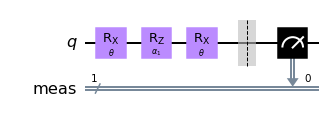

In [ ]:
theta = Parameter(r"$\theta$")
alpha1 = Parameter(r"$\alpha_1$")
qc = QuantumCircuit(1)
qc.rx(theta, 0)
qc.rz(alpha1, 0)
qc.rx(theta, 0)
qc.measure_all()
qc.draw("mpl")

We can now look at the performance of the code with some randomly initialized weight in predicting the appropiate label.

In [ ]:
def get_accuracy(
    qc: QuantumCircuit, alpha: float, weight: float,
    xvals: List[float], yvals: List[int]
) -> Union[float, List[int]]:
    """
    Calculates the accuracy of the circuit for a given set of data.

    Args:
      qc: the quantum circuit
      alphas: the training parameter
      weights: the weights for the inputs
      xvals: the input values
      yvals: the labels
    Returns:
      The accuracy and the predicted labels.
    """
    pred_labels = np.zeros(len(xvals))
    accurate_prediction = 0
    for ii, xinput, yinput in zip(range(len(xvals)), xvals, yvals.astype(int)):
        # set the circuit parameter
        circuit = qc.assign_parameters(
            {theta: weight*xinput,
             alpha1: alpha,
             },
            inplace=False,
        )
        # run the job and obtain the counts
        Nshots = 4000
        job = sim.run(circuit, shots=Nshots)
        counts1 = job.result().get_counts()

        # obtain the predicted label on average
        if "0" in counts1:
            pred_label = 1 * (counts1["0"] < Nshots/2)
        else:
            pred_label = 1
        pred_labels[ii] = pred_label
        if yinput == pred_label:
            accurate_prediction += 1
    return accurate_prediction / len(yvals), pred_labels

The circuit has an accuracy of 0.275


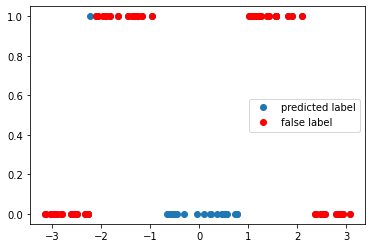

In [ ]:
weight = 1
alpha = np.pi/4

accuracy, y_pred = get_accuracy(qc, alpha=alpha, weight=weight, xvals=x_train, yvals=y_train)

false_label = abs(y_pred - y_train) > 0

x_false = x_train[false_label]
y_false = y_pred[false_label]

print(f"The circuit has an accuracy of {accuracy}")
f, ax = plt.subplots()
ax.plot(x_train, y_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()

## Training

We once again have to train the circuit. However, this time it does not have a single training variable, but four. We therefore have to fall back to [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html) package to optimize the target function.

In [ ]:
from scipy.optimize import minimize

In [ ]:
def get_cost_for_circ(xvals, yvals, machine=sim):
    """
    Runs parametrized circuit

    Args:
        x: position of the dot
        y: its state label
        params: parameters of the circuit
    """

    def execute_circ(params_flat):
        weight = params_flat[0]
        alpha = params_flat[1]
        accuracy, y_pred = get_accuracy(qc, alpha=alpha, weight=weight, xvals=xvals, yvals=yvals)
        print(f"accuracy = {accuracy}")
        return 1-accuracy

    return execute_circ

In [ ]:
total_cost = get_cost_for_circ(x_train, y_train, sim)

# initial parameters which are randomly initialized
np.random.seed(123)
params = np.random.uniform(size=2)
params_flat = params.flatten()

# minimze with COBYLA optimize, which often performs quite well
res = minimize(total_cost, params_flat, method="COBYLA")

accuracy = 0.675
accuracy = 0.6
accuracy = 0.775
accuracy = 0.65
accuracy = 0.4
accuracy = 0.9
accuracy = 0.65
accuracy = 0.65
accuracy = 0.825
accuracy = 0.825
accuracy = 1.0
accuracy = 0.925
accuracy = 0.9625
accuracy = 1.0
accuracy = 0.9625
accuracy = 0.975
accuracy = 1.0
accuracy = 1.0
accuracy = 1.0
accuracy = 1.0
accuracy = 1.0
accuracy = 1.0


We can see that the accuracy is converging throughout the training quite nicely and it is now time to look into the optimal training parameters.

In [ ]:
opt_weight, opt_alpha = res.x
print(f"optimal weight = {opt_weight}")
print(f"optimal alpha = {opt_alpha}")

optimal weight = 0.5093757145525236
optimal alpha = 1.3032510317367447


We can now test the accuracy on the optimal value of the weights again to test the accuracy.

The trained circuit has an accuracy of 1.0


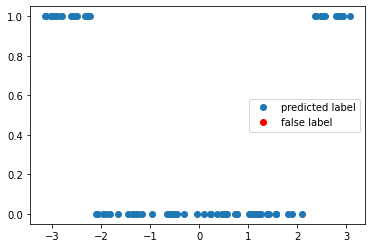

In [ ]:
accuracy, y_pred = get_accuracy(qc, weight=opt_weight, alpha = opt_alpha, xvals=x_train, yvals=y_train)

false_label = abs(y_pred - y_train) > 0

x_false = x_train[false_label]
y_false = y_pred[false_label]

f, ax = plt.subplots()
ax.plot(x_train, y_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()


print(f"The trained circuit has an accuracy of {accuracy:.2}")

## Test

Having finished the training, we can test the circuit now on data points that it has never seen.

The circuit has a test accuracy of 1.0


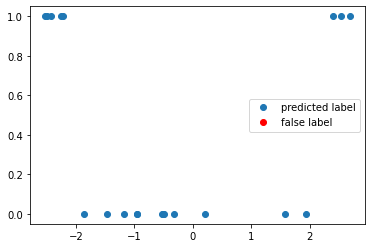

In [ ]:
test_accuracy, y_test_pred = get_accuracy(
    qc, weight=opt_weight, alpha = opt_alpha, xvals=x_test, yvals=y_test
)

false_label = abs(y_test_pred - y_test) > 0

x_false = x_test[false_label]
y_false = y_test_pred[false_label]

print(f"The circuit has a test accuracy of {test_accuracy:.2}")
f, ax = plt.subplots()
ax.plot(x_test, y_test_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()

## Summary and outlook

In this tutorial, we have seen that the extension of the circuit to deeper structures allows us to learn training sets, which were previously impossible to evaluate. In the next tutorials, we will extend these circuits in two directions:

1. Work with larger dimensions of input parameters. This is what we would like to do quantum machine learning anyways and where the main innovation of the data reuploading circuits lies.
2. Work on circuits with multiple qubits to classify different classes and introduce entanglement in a systematic fashion. 